### Task 1
### Fine-tuning VGG16


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.metrics as skm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Load Dataset usign torchvision image loader

In [2]:
data_dir = 'dataset'

In [3]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=5, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [4]:
print(train_data.class_to_idx)

{'covid-19': 0, 'normal': 1, 'pneumonia': 2}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


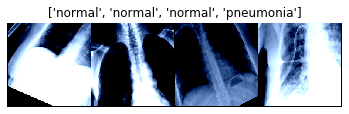

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
valid_inputs, valid_classes = next(iter(validationloader))
show_databatch(inputs, classes)

##  Multi Label Focal Loss

In [ ]:
class MultiLabelFocalLoss(nn.modules.loss._WeightedLoss):
    
    def __init__(self,  alpha=1, gamma=3, weight=None, size_average=None, ignore_index=-100,
                 reduce=None, reduction='mean', balance_param=0.25):
        
        super().__init__(weight, size_average, reduce, reduction)
        
        self.gamma = gamma
        self.alpha = alpha
        
    def forward(self, inLayer, outLayer):
        
        assert len(inLayer) == len(outLayer)
        assert inLayer.size(0) == outLayer.size(0)
        assert inLayer.size(1) == outLayer.size(1)
        
        criterion = nn.BCEWithLogitsLoss()
        loss = -criterion(inLayer, outLayer)
        pt = torch.exp(loss)
        
        focLoss = -self.alpha*((1-pt)**self.gamma)*torch.log(pt)
        return focLoss

### Load pre-trained VGG-16

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

In [ ]:
print(vgg16.classifier[6])

### Modifying FC Layers

In [ ]:
vgg16.classifier[6]=nn.Linear(in_features=4096, out_features=len(class_names), bias=True)
print(vgg16)

### Loss fucntion and optimizer

In [ ]:
Epochs = 20
#criterion = nn.BCEWithLogitsLoss()
criterion = MultiLabelFocalLoss(gamma = 2, alpha =0.25)
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

## Auxiliary Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]



def ValidationExec(validationloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    v_loss = 0.0
    running_loss = 0.0
    v_total = 0.0
    v_correct = 0.0
    ran = 0.0
    
    validation_labels = []
    validation_prediction = []
    validation_labels_m = []
    validation_prediction_m = []
    
    with torch.no_grad():
            for v_data in validationloader:
                
                #getting data and converting to gpu
                v_images, v_labels = v_data
                v_images, v_labels = v_images.to(device), v_labels.to(device)
                
                #correcting labels
                v_labels = torch.nn.functional.one_hot(v_labels, num_classes=len(class_names)) * 1.0
                v_labels[v_labels[:,0] == 1, 2] = 1
                
                #feed forward
                v_outputs = vgg16(v_images)
                
                #prediction and loss
                m = torch.nn.Sigmoid()
                v_predicted = m(v_outputs).round()
                v_loss = criterion.forward(v_outputs, v_labels)
                
                
                
                ## accuracy per batch
                v_total += v_labels.size(0)
                for i in range(0, v_labels.size(0)):
                
                    x = v_labels[i]==v_predicted[i]
                    if False in x:
                        continue
                    else:
                        v_correct += 1
                
                running_loss += v_loss.item()
                ran += 1
                
                
                ## building data for confusion Matrix
                validation_labels.extend(v_labels)
                validation_prediction.extend(v_predicted)
                for i in range(0, v_labels.size(0)):
                    validation_labels_m.append(v_labels[i])
                    validation_prediction_m.append(v_predicted[i])

                
                #clearing data
                v_images, v_labels = v_images.to("cpu"), v_labels.to("cpu")
                
    return v_correct/v_total, running_loss/ran, validation_labels, validation_prediction, validation_labels_m, validation_prediction_m

### Training

In [ ]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train(True)
print(device)

training_loss = []
acc_training = []
validation_loss = []
acc_validation = []

training_labels = []
training_prediction = []

training_labels_m = []
training_prediction_m = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    
    v_acc = 0
    v_loss = 0
    
    ran = 0.0
    
    running_loss = 0.0
    total_training = 0.0
    correct_training = 0.0
    
    pbar = tqdm(enumerate(trainloader))
    
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #multilabel one hot coding assignment
        labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names)) * 1.0
        labels[labels[:,0] == 1, 2] = 1
        
       
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        m = torch.nn.Sigmoid()
        predicted = m(outputs).round() #---> computing accuracy
        
        tot_labels = labels.size(0)
        
        cor_training = 0
        for j in range(0, tot_labels):
            #if np.array_equal(predicted.numpy()[i],labels.numpy()[i]):
            x = labels[j]==predicted[j]
            if False in x:
                continue
            else:
                cor_training += 1
    
        total_training += tot_labels
        correct_training += cor_training
        
        loss = criterion.forward(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        ## building data for confusion Matrix
        if epoch == Epochs-1:
            training_labels.extend(labels)
            training_prediction.extend(predicted)
            for j in range(0, labels.size(0)):
                training_labels_m.append(labels[j])
                training_prediction_m.append(predicted[j])
        
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data, cor_training/tot_labels ))
        ran += 1
    #validation data    
    v_acc, v_loss, validation_labels, validation_prediction, validation_labels_mv, validation_prediction_mv = ValidationExec(validationloader)
    print("Validation loss: " + str(v_loss))
    print("Validation acc: " + str(v_acc))
    
    
    training_loss.append(running_loss/ran)
    acc_training.append(correct_training/total_training)
    acc_validation.append(v_acc)
    validation_loss.append(v_loss)
    
    #after epoch statistics:
    print("After epoch training loss: " + str(training_loss[-1]))
    print("After epoch training acc: " + str(acc_training[-1]))
    
    torch.save(vgg16.state_dict(), 'vgg16_with_focal_alpha_loss.pth')

print('Finished Training')

In [ ]:
x =np.array([[1, 0, 1], [0, 1, 0]])
b =torch.tensor([[0, 0, 1], [0, 1, 0]]).numpy()
print(np.array_equal(x,b))
print(torch.eq(torch.tensor([1, 0, 1]), torch.tensor([1, 0, 0])))

## Confusion Matrix and other Stats

In [ ]:
print(training_labels_m[0].data.cpu().numpy())

In [ ]:
print(training_labels_m[0].size(0))
tl = []
tp = []
for i in range(0, len(training_labels_m)):
    tl.append(training_labels_m[i].data.cpu().numpy())
    tp.append(training_prediction_m[i].data.cpu().numpy())

cm = skm.multilabel_confusion_matrix(tl, tp)
print(cm)
clm = skm.classification_report(tl,tp)
print(clm)

In [ ]:

tl = []
tp = []
for i in range(0, len(validation_labels_mv)):
    tl.append(validation_labels_mv[i].data.cpu().numpy())
    tp.append(validation_prediction_mv[i].data.cpu().numpy())

cm = skm.multilabel_confusion_matrix(tl, tp)
print(cm)
clm = skm.classification_report(tl,tp)
print(clm)

In [ ]:
plt.plot(training_loss)

In [ ]:
plt.plot(acc_training)

In [ ]:
plt.plot(acc_validation)

In [ ]:
plt.plot(validation_loss)

### Testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

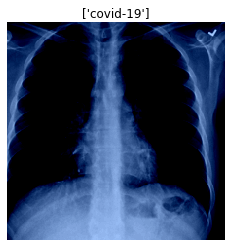

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#loading required model
testModel = models.vgg16(pretrained=True)
testModel.classifier[6]=nn.Linear(in_features=4096, out_features=len(class_names), bias=True)
stateDict= torch.load("vgg16_without_focal_loss.pth")
testModel.load_state_dict(stateDict)
testModel.to(device)
print(testModel)
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [18]:
tot_predicted = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        
        
        outputs = testModel(images)
        m = torch.nn.Sigmoid()
        predicted = m(outputs).round() #---> computing accuracy
        
        for j in range(0, labels.size(0)):
            tot_predicted.append(predicted[j])
        
print("Finished Testing")
print("Generating csv...")

tp = []

for i in range(0, len(tot_predicted)):
    tp.append(tot_predicted[i].data.cpu().numpy())

tp = np.array(tp)
tp[:,[1, 2]] = tp[:,[2, 1]] # now it is according to our requirements

tn = []

#generating names
for i in range(0, 629):
    tn.append(str(i)+".png")

print("total predictions")
print(tp.shape)
print("total images")
print(len(tn))
    
#writing file
fp = open("results.csv", "w")
for i in range(0, len(tn)):
    line = tn[i] + "," + str(int(tp[i][0])) + "," + str(int(tp[i][1])) + "," + str(int(tp[i][2])) + str("\n")
    fp.write(line)
fp.close()
print("finished writing file")

Finished Testing
Generating csv...
total predictions
(629, 3)
total images
629
finished writing file


In [17]:
strr = "\n"
print(strr)
p = []
x = np.array([1, 2, 3])
b = np.array([4, 5, 6])
c = np.array([7, 8, 9])
p.append(x)
p.append(b)
p.append(c)
print(p)
p = np.array(p)
print(p)
print(p.shape)
p[:, [1, 2]] = p[:, [2, 1]]
print(p)



[array([1, 2, 3]), array([4, 5, 6]), array([7, 8, 9])]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
(3, 3)
[[1 3 2]
 [4 6 5]
 [7 9 8]]


## Task 1 Resnet-18

### Load pre-trained Resnet-18

In [ ]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)


## Modifying Resnet-18

In [ ]:
layers = []
itr = nn.Sequential
layers.append(nn.Linear(resnet18.fc.in_features, len(class_names)))
print(layers)
resnet18.fc= nn.Sequential(*layers)
print(resnet18)

## Loss Function and Optimizer

In [ ]:
Epochs = 30
#criterion = nn.BCEWithLogitsLoss()
criterion = MultiLabelFocalLoss(gamma = 2, alpha = 0.25)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

## Auxilliary Functions

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]



def ValidationExec(validationloader):
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    v_loss = 0.0
    running_loss = 0.0
    v_total = 0.0
    v_correct = 0.0
    ran = 0.0
    
    validation_labels = []
    validation_prediction = []
    validation_labels_m = []
    validation_prediction_m = []
    
    with torch.no_grad():
            for v_data in validationloader:
                
                #getting data and converting to gpu
                v_images, v_labels = v_data
                v_images, v_labels = v_images.to(device), v_labels.to(device)
                
                #correcting labels
                v_labels = torch.nn.functional.one_hot(v_labels, num_classes=len(class_names)) * 1.0
                v_labels[v_labels[:,0] == 1, 2] = 1
                
                #feed forward
                v_outputs = resnet18(v_images)
                
                #prediction and loss
                m = torch.nn.Sigmoid()
                v_predicted = m(v_outputs).round()
                v_loss = criterion(v_outputs, v_labels)
                
                
                
                ## accuracy per batch
                v_total += v_labels.size(0)
                for i in range(0, v_labels.size(0)):
                
                    x = v_labels[i]==v_predicted[i]
                    if False in x:
                        continue
                    else:
                        v_correct += 1
                
                running_loss += v_loss.item()
                ran += 1
                
                
                ## building data for confusion Matrix
                validation_labels.extend(v_labels)
                validation_prediction.extend(v_predicted)
                for i in range(0, v_labels.size(0)):
                    validation_labels_m.append(v_labels[i])
                    validation_prediction_m.append(v_predicted[i])

                
                #clearing data
                v_images, v_labels = v_images.to("cpu"), v_labels.to("cpu")
                
    return v_correct/v_total, running_loss/ran, validation_labels, validation_prediction, validation_labels_m, validation_prediction_m

## Training

In [ ]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train(True)
print(device)

training_loss = []
acc_training = []
validation_loss = []
acc_validation = []

training_labels = []
training_prediction = []

training_labels_m = []
training_prediction_m = []

for epoch in range(Epochs):  # loop over the dataset multiple times
    
    
    v_acc = 0
    v_loss = 0
    
    ran = 0.0
    
    running_loss = 0.0
    total_training = 0.0
    correct_training = 0.0
    
    pbar = tqdm(enumerate(trainloader))
    
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #multilabel one hot coding assignment
        labels = torch.nn.functional.one_hot(labels, num_classes=len(class_names)) * 1.0
        labels[labels[:,0] == 1, 2] = 1
        
       
        
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        m = torch.nn.Sigmoid()
        predicted = m(outputs).round() #---> computing accuracy
        
        tot_labels = labels.size(0)
        
        cor_training = 0
        for j in range(0, tot_labels):
            #if np.array_equal(predicted.numpy()[i],labels.numpy()[i]):
            x = labels[j]==predicted[j]
            if False in x:
                continue
            else:
                cor_training += 1
    
        total_training += tot_labels
        correct_training += cor_training
        
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        ## building data for confusion Matrix
        if epoch == Epochs-1:
            training_labels.extend(labels)
            training_prediction.extend(predicted)
            for j in range(0, labels.size(0)):
                training_labels_m.append(labels[j])
                training_prediction_m.append(predicted[j])
        
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data, cor_training/tot_labels ))
        ran += 1
    #validation data    
    v_acc, v_loss, validation_labels, validation_prediction, validation_labels_mv, validation_prediction_mv = ValidationExec(validationloader)
    print("Validation loss: " + str(v_loss))
    print("Validation acc: " + str(v_acc))
    
    
    training_loss.append(running_loss/ran)
    acc_training.append(correct_training/total_training)
    acc_validation.append(v_acc)
    validation_loss.append(v_loss)
    
    #after epoch statistics:
    print("After epoch training loss: " + str(training_loss[-1]))
    print("After epoch training acc: " + str(acc_training[-1]))
    
    torch.save(resnet18.state_dict(), 'resnet18_with_focal_alpha_loss.pth')

print('Finished Training')

## Confusion Matrix and other Stats

In [ ]:
## this is for training

tl = []
tp = []
for i in range(0, len(training_labels_m)):
    tl.append(training_labels_m[i].data.cpu().numpy())
    tp.append(training_prediction_m[i].data.cpu().numpy())

cm = skm.multilabel_confusion_matrix(tl, tp)
print(cm)
clm = skm.classification_report(tl,tp)
print(clm)

In [ ]:
tl = []
tp = []
for i in range(0, len(validation_labels_mv)):
    tl.append(validation_labels_mv[i].data.cpu().numpy())
    tp.append(validation_prediction_mv[i].data.cpu().numpy())

cm = skm.multilabel_confusion_matrix(tl, tp)
print(cm)
clm = skm.classification_report(tl,tp)
print(clm)

In [ ]:
plt.plot(training_loss)

In [ ]:
plt.plot(acc_training)

In [ ]:
plt.plot(acc_validation)

In [ ]:
plt.plot(validation_loss)

## Testing

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [ ]:
correct = 0
total = 0
predicted = []
labels = []

tot_predicted = []
tot_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        tot_predicted.extend(predicted)
        tot_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
## this is for testing

# Scores
pref = perf_measure(tot_labels, tot_predicted)
print(pref)
#confusion Matrix
tl = []
tp = []
for i in range(0, len(tot_labels)):
    tl.append(tot_labels[i].item())
    tp.append((tot_predicted[i].item()))

plot_confusion_matrix(tl, tp, class_names)
fig = plt.gcf()
fig.show()

In [ ]:
recall = (pref[0]*1.0) / (1.0 * pref[0] + pref[3])
precision = (pref[0]*1.0) / (1.0 * pref[0] + pref[1])
f1 = (2 * recall * precision)/ (recall + precision)
print("F1 score is ", f1)

## Task 2 Vgg16

## Loading VGG16

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)


## Modify VGG16

In [ ]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[0:4] # Remove last layer
#print(features)
features[0].out_features =(8*10)+100 #roll number is bscs17008
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)
#print(features)


# Freeze training for all layers
#for param in vgg16.features.parameters():
#    param.requires_grad = False
    
#Now unfreezing first convolution layer
#vgg16.features[0].weight.requires_grad = True
#vgg16.features[0].bias.requires_grad = True

#Now unfreezing first 4 convolution layers
#vgg16.features[0].weight.requires_grad = True
#vgg16.features[0].bias.requires_grad = True
#vgg16.features[2].weight.requires_grad = True
#vgg16.features[2].bias.requires_grad = True
#vgg16.features[5].weight.requires_grad = True
#vgg16.features[5].bias.requires_grad = True
#vgg16.features[7].weight.requires_grad = True
#vgg16.features[7].bias.requires_grad = True


## adding layer
vgg16.classifier = nn.Sequential(*features)

## Setting Hyperparameters

In [ ]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

## Task 2 Resnet18

## Loading Resnet18

In [ ]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)


## Modifying Resnet18

In [ ]:
layers = []
itr = nn.Sequential
layers.append(nn.Linear(resnet18.fc.in_features, 180))
layers.append(nn.Linear(180, len(class_names)))
resnet18.fc= nn.Sequential(*layers)

#freezing all layers
for i in resnet18.children():
    for param in i.parameters():
        param.requires_grad = False
#print(resnet18)

#fc layer unfreezing
for i in resnet18.fc:
    for param in i.parameters():
        param.requires_grad = True
        
#unfreezing 5 convolution layer
resnet18.conv1.weight.requires_grad = True
resnet18.layer1[0].conv1.weight.requires_grad = True
resnet18.layer1[0].conv2.weight.requires_grad = True
resnet18.layer1[1].conv1.weight.requires_grad = True
resnet18.layer1[1].conv2.weight.requires_grad = True

## Setting Hyperparameters

In [ ]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)